In [7]:
!pip install jovian --upgrade --quiet

In [3]:
!pip install numpy matplotlib torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 159.3MB 43kB/s 
     |████████████████████████████████| 11.8MB 218kB/s 
     |████████████████████████████████| 7.6MB 8.3MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [9]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

matplotlib.rcParams['figure.facecolor']='#ffffff'

In [10]:
dataset=MNIST(root='data/',download=True,transform=ToTensor())

In [18]:
val_size=10000
train_size=len(dataset)-val_size
train_ds,val_ds=random_split(dataset,[train_size,val_size])
len(train_ds),len(val_ds)

(50000, 10000)

In [19]:
batch_size=128

In [20]:
train_loader=DataLoader(train_ds,batch_size,shuffle=True,num_workers=4,pin_memory=True)
val_loader=DataLoader(val_ds,batch_size*2,num_workers=4,pin_memory=True)

images.shape: torch.Size([128, 1, 28, 28])


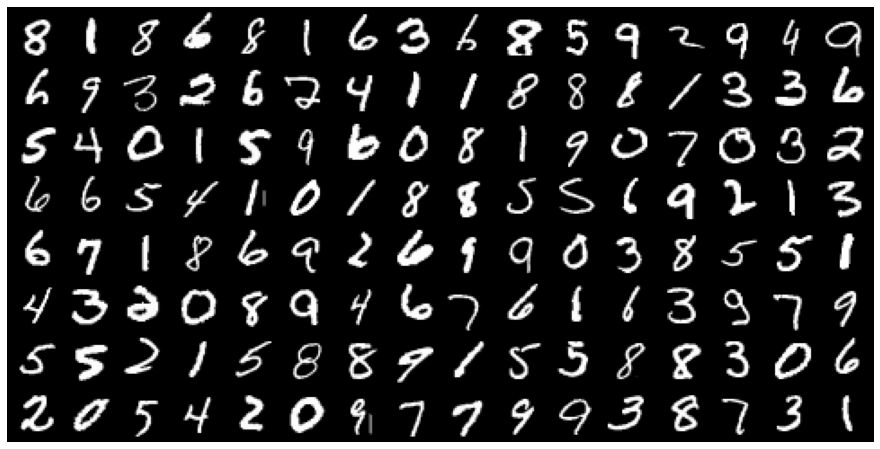

In [21]:
for images,_ in train_loader:
  print('images.shape:',images.shape)
  plt.figure(figsize=(16,8))
  plt.axis('off')
  plt.imshow(make_grid(images,nrow=16).permute(1,2,0))
  break

In [22]:
for images,labels in train_loader:
  print('images.shape: ',images.shape)
  inputs=images.reshape(-1,784)
  print('inputs.shape: ',inputs.shape)
  break

images.shape:  torch.Size([128, 1, 28, 28])
inputs.shape:  torch.Size([128, 784])


In [23]:
input_size=inputs.shape[-1]
hidden_size=32

In [24]:
layer1=nn.Linear(input_size,hidden_size)

In [25]:
inputs.shape

torch.Size([128, 784])

In [26]:
layer1_outputs=layer1(inputs)
print('layer1_outputs.shape: ',layer1_outputs.shape)

layer1_outputs.shape:  torch.Size([128, 32])


In [27]:
layer1_outputs_direct=inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 32])

In [28]:
torch.allclose(layer1_outputs,layer1_outputs_direct,1e-3)

True

In [29]:
F.relu(torch.tensor([[1,-1,0],[-0.1,.2,3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

In [31]:
relu_outputs=F.relu(layer1_outputs)
print('min(layer1_outputs): ',torch.min(layer1_outputs).item())
print('min(relu_outputs): ',torch.min(relu_outputs).item())

min(layer1_outputs):  -0.7251176238059998
min(relu_outputs):  0.0


In [32]:
output_size=10
layer2=nn.Linear(hidden_size,output_size)

In [33]:
layer2_outputs=layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


In [34]:
inputs.shape

torch.Size([128, 784])

In [35]:
F.cross_entropy(layer2_outputs,labels)

tensor(2.3115, grad_fn=<NllLossBackward>)

In [36]:
outputs=(F.relu(inputs @ layer1.weight.t()+layer1.bias)) @ layer2.weight.t() + layer2.bias

In [37]:
torch.allclose(outputs,layer2_outputs,1e-3)

True

In [38]:
outputs2=(inputs @ layer1.weight.t() + layer1.bias) @ layer2.weight.t() + layer2.bias

In [39]:
combined_layer=nn.Linear(input_size,output_size)

combined_layer.weight.data=layer2.weight @ layer1.weight
combined_layer.bias.data=layer1.bias @ layer2.weight.t() + layer2.bias

In [40]:
outputs3=inputs @ combined_layer.weight.t() + combined_layer.bias

In [41]:
torch.allclose(outputs2,outputs3,1e-3)

True

In [42]:
!pip install jovian --upgrade --quiet

In [43]:
import jovian

In [44]:
jovian.commit(project='04-feedforward-neural-net')

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/sagarp3199/04-feedforward-neural-net


'https://jovian.ai/sagarp3199/04-feedforward-neural-net'

In [45]:
class MnistModel(nn.Module):
  def __init__(self,in_size,hidden_size,out_size):
    super().__init__()
    self.linear1=nn.Linear(in_size,hidden_size)
    self.linear2=nn.Linear(hidden_size,out_size)
  
  def forward(self,xb):
    xb=xb.view(xb.size(0),-1)
    out=self.linear1(xb)
    out=F.relu(out)
    out=self.linear2(out)
    return out

  def training_step(self,batch):
    images,labels=batch
    out=self(images)
    loss=F.cross_entropy(out,labels)
    return loss
  
  def validation_step(self,batch):
    images,labels=batch
    out=self(images)
    loss=F.cross_entropy(out,labels)
    acc=accuracy(out,labels)
    return {'val_loss': loss,'val_acc':acc}

  def validation_epoch_end(self,outputs):
    batch_losses=[x['val_loss']for x in outputs]
    epoch_loss=torch.stack(batch_losses).mean()
    batch_accs=[x['val_acc']for x in outputs]
    epoch_acc=torch.stack(batch_accs).mean()
    return {'val_loss': epoch_loss.item(),'val_acc': epoch_acc.item()}

  def epoch_end(self,epoch,result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch,result['val_loss'],result['val_acc']))

In [46]:
def accuracy(outputs,labels):
  _,preds=torch.max(outputs,dim=1)
  return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [47]:
input_size=784
hidden_size=32
num_classes=10

In [48]:
model=MnistModel(input_size,hidden_size=32,out_size=num_classes)

In [50]:
for t in model.parameters():
  print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [51]:
for images,labels in train_loader:
  outputs=model(images)
  loss=F.cross_entropy(outputs,labels)
  print('Loss:',loss.item())
  break

print('outputs.shape: ',outputs.shape)
print('Sample outputs : \n',outputs[:2].data)

Loss: 2.302157402038574
outputs.shape:  torch.Size([128, 10])
Sample outputs : 
 tensor([[ 0.0663,  0.0745, -0.0517,  0.0637, -0.1395,  0.0858,  0.0343,  0.0635,
          0.1005, -0.0732],
        [-0.0048,  0.1597, -0.0310, -0.0157, -0.0577, -0.0393, -0.0096, -0.0365,
          0.0852, -0.1265]])


In [52]:
torch.cuda.is_available()

False

In [53]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [54]:
device=get_default_device()
device

device(type='cpu')

In [55]:
def to_device(data,device):
  if isinstance(data,(list,tuple)):
    return [to_device(x,device) for x in data]
  return data.to(device,non_blocking=True)

In [58]:
for images,labels in train_loader:
  print(images.shape)
  images=to_device(images,device)
  print(images.device)
  break

torch.Size([128, 1, 28, 28])
cpu


In [59]:
class DeviceDataLoader():
  def __init__(self,dl,device):
    self.dl=dl
    self.device=device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b,self.device)

  def __len__(self):
    return len(self.dl)

In [60]:
train_loader=DeviceDataLoader(train_loader,device)
val_loader=DeviceDataLoader(val_loader,device)

In [62]:
for xb,yb in val_loader:
  print('xb.device: ',xb.device)
  print('yb: ',yb)
  break

xb.device:  cpu
yb:  tensor([7, 0, 3, 4, 8, 3, 0, 0, 4, 0, 5, 1, 7, 6, 7, 1, 1, 6, 5, 7, 0, 7, 6, 0,
        1, 8, 0, 6, 2, 8, 7, 3, 6, 8, 8, 7, 8, 6, 3, 5, 0, 8, 6, 0, 9, 4, 5, 4,
        2, 6, 9, 8, 1, 1, 1, 6, 8, 2, 2, 9, 9, 5, 0, 3, 3, 0, 7, 2, 0, 4, 0, 7,
        9, 8, 0, 1, 3, 9, 1, 9, 5, 5, 2, 8, 4, 6, 6, 9, 4, 2, 7, 8, 8, 7, 9, 2,
        5, 0, 8, 1, 8, 7, 5, 1, 9, 4, 4, 3, 2, 3, 2, 7, 2, 6, 5, 8, 5, 8, 0, 8,
        6, 4, 8, 1, 1, 9, 0, 2, 0, 3, 6, 2, 3, 3, 5, 0, 6, 4, 5, 8, 7, 1, 9, 2,
        1, 3, 6, 3, 2, 1, 2, 2, 4, 1, 2, 3, 9, 7, 7, 5, 2, 5, 1, 0, 2, 5, 1, 0,
        8, 6, 6, 6, 5, 8, 7, 2, 0, 5, 4, 1, 5, 3, 1, 6, 0, 0, 1, 9, 5, 1, 8, 5,
        1, 8, 2, 5, 1, 5, 8, 2, 5, 7, 8, 2, 0, 0, 8, 6, 1, 9, 6, 4, 7, 7, 1, 3,
        3, 9, 2, 5, 6, 6, 3, 8, 6, 8, 6, 7, 2, 2, 8, 7, 2, 3, 9, 6, 3, 2, 9, 7,
        8, 2, 4, 1, 3, 3, 9, 1, 8, 0, 6, 9, 7, 0, 9, 2])


In [63]:
def evaluate(model,val_loader):
  outputs=[model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs,lr,model,train_loader,val_loader,opt_func=torch.optim.SGD):
  history=[]
  optimizer=opt_func(model.parameters(),lr)
  for epoch in range(epochs):
    for batch in train_loader:
      loss=model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    result=evaluate(model,val_loader)
    model.epoch_end(epoch,result)
    history.append(result)
  return history

In [64]:
model=MnistModel(input_size,hidden_size=hidden_size,out_size=num_classes)
to_device(model,device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [65]:
history=[evaluate(model,val_loader)]
history

[{'val_acc': 0.10615234076976776, 'val_loss': 2.312070846557617}]

In [66]:
history += fit(5,0.5,model,train_loader,val_loader)

Epoch [0], val_loss: 0.2730, val_acc: 0.9162
Epoch [1], val_loss: 0.1750, val_acc: 0.9461
Epoch [2], val_loss: 0.1398, val_acc: 0.9582
Epoch [3], val_loss: 0.1485, val_acc: 0.9539
Epoch [4], val_loss: 0.1273, val_acc: 0.9622


In [67]:
history += fit (5,0.1,model,train_loader,val_loader)

Epoch [0], val_loss: 0.1139, val_acc: 0.9670
Epoch [1], val_loss: 0.1105, val_acc: 0.9677
Epoch [2], val_loss: 0.1101, val_acc: 0.9669
Epoch [3], val_loss: 0.1116, val_acc: 0.9668
Epoch [4], val_loss: 0.1078, val_acc: 0.9681


Text(0.5, 1.0, 'Loss vs No. of epochs')

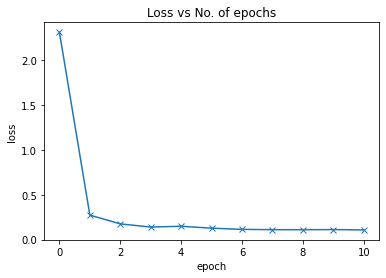

In [68]:
losses = [x['val_loss'] for x in history]
plt.plot(losses,'-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs No. of epochs')

Text(0.5, 1.0, 'Accuracy vs No. of epochs')

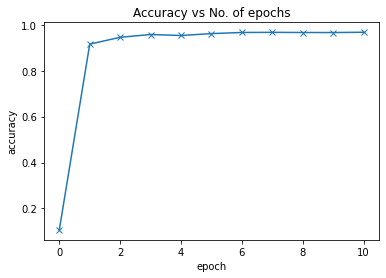

In [69]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs No. of epochs')

In [70]:
!pip install jovian --upgrage -q


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --upgrage


In [72]:
import jovian

In [73]:
jovian.commit(project='04-feedforward-neural-net')

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/sagarp3199/04-feedforward-neural-net


'https://jovian.ai/sagarp3199/04-feedforward-neural-net'

In [75]:
test_dataset=MNIST(root='data/',train=False,transform=ToTensor())

In [78]:
def predict_image(img,model):
  xb=to_device(img.unsqueeze(0),device)
  yb=model(xb)
  _,preds=torch.max(yb,dim=1)
  return preds[0].item()

Label:  7  Predicted:  7


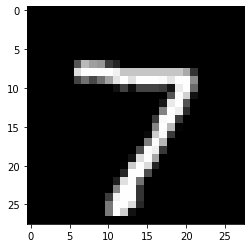

In [79]:
img,label=test_dataset[0]
plt.imshow(img[0],cmap='gray')
print('Label: ',label,' Predicted: ',predict_image(img,model))

Label:  9  Predicted:  9


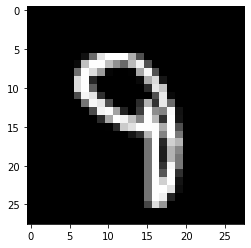

In [82]:
img,label=test_dataset[193]
plt.imshow(img[0],cmap='gray')
print('Label: ',label,' Predicted: ',predict_image(img,model))

Label:  0  Predicted:  0


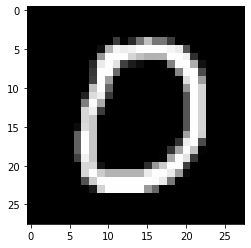

In [81]:
img,label=test_dataset[10]
plt.imshow(img[0],cmap='gray')
print('Label: ',label,' Predicted: ',predict_image(img,model))

In [83]:
test_loader=DeviceDataLoader(DataLoader(test_dataset,batch_size=256),device)
result=evaluate(model,test_loader)
result

{'val_acc': 0.968457043170929, 'val_loss': 0.10266430675983429}

In [84]:
jovian.log_metrics(test_loss=result['val_loss'],test_acc=result['val_acc'])

[jovian] Metrics logged.


In [85]:
torch.save(model.state_dict(),'mnist-feedforward.pth')

In [ ]:
jovian.commit(project='04-feedforward-neural-net',environment=None,outpu)